# Testing Three Structured Output Methods with Amazon Nova Models

This notebook demonstrates three different approaches to get structured JSON output from Amazon Nova models:
1. **Output Schema Method**: Providing explicit schema instructions
2. **Prefilling Method**: Using assistant content prefilling to guide output format
3. **Tool Use Method**: Using toolChoice to enforce structured output

We'll test each method on Nova Pro, Lite, and Micro models with 10 iterations each.

In [ ]:
%pip install ipywidgets pandas numpy matplotlib tqdm boto3

In [68]:
# Import necessary libraries
import boto3
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

In [69]:
# Create Bedrock runtime client
bedrock_runtime = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-west-2'  # Change to your preferred region
)

## Define Nova Models to Test

In [70]:
# Define the Nova models to test
nova_models = {
    "Pro": "us.amazon.nova-pro-v1:0",
    "Lite": "us.amazon.nova-lite-v1:0",
    "Micro": "us.amazon.nova-micro-v1:0"
}

# Number of test iterations per method per model
iterations = 10

# Test prompt for questionnaire agent
base_prompt = "Ask the user for the name of their healthcare practice and provide a friendly response"

## Method 1: Output Schema Approach

In [71]:
def test_output_schema_method(model_id, prompt):
    """Test using explicit output schema instructions"""
    start_time = time.time()
    
    schema_prompt = f"""{prompt}
    
You MUST answer in JSON format only. Please follow the output schema below:

Output Schema:
{{
    "questionText": "The question to ask the user",
    "questionType": "text|number|multipleChoice|date",
    "friendlyResponse": "A friendly message to accompany the question",
    "nextQuestionId": "optional next question identifier"
}}"""
    
    request_body = {
        "messages": [
            {
                "role": "user",
                "content": [{"text": schema_prompt}]
            }
        ],
        "inferenceConfig": {
            "maxTokens": 1000,
            "temperature": 0,
            "topP": 1,
            "topK": 1
        }
    }
    
    try:
        response = bedrock_runtime.invoke_model(
            modelId=model_id,
            body=json.dumps(request_body)
        )
        
        response_body = json.loads(response["body"].read().decode("utf-8"))
        
        # Extract the text content
        content = response_body["output"]["message"]["content"][0]["text"]
        
        # Try to parse as JSON
        try:
            json_output = json.loads(content)
            is_valid_json = True
        except:
            # Try to extract JSON from text if it's wrapped
            import re
            json_match = re.search(r'\{.*\}', content, re.DOTALL)
            if json_match:
                try:
                    json_output = json.loads(json_match.group())
                    is_valid_json = True
                except:
                    json_output = None
                    is_valid_json = False
            else:
                json_output = None
                is_valid_json = False
        
        return {
            "success": True,
            "is_valid_json": is_valid_json,
            "json_output": json_output,
            "raw_content": content,
            "duration": time.time() - start_time
        }
    except Exception as e:
        return {
            "success": False,
            "error": str(e),
            "duration": time.time() - start_time
        }

## Method 2: Prefilling Approach

In [72]:
def test_prefilling_method(model_id, prompt):
    """Test using assistant content prefilling"""
    start_time = time.time()
    
    prefill_prompt = f"""{prompt}
    
Your response should be in JSON format with the following keys: questionText, questionType, friendlyResponse, nextQuestionId."""
    
    request_body = {
        "messages": [
            {
                "role": "user",
                "content": [{"text": prefill_prompt}]
            },
            {
                "role": "assistant",
                "content": [{"text": "Here is the JSON response: ```json\n{"}]
            }
        ],
        "inferenceConfig": {
            "maxTokens": 1000,
            "temperature": 0,
            "topP": 1,
            "topK": 1,
            "stopSequences": ["```"]
        }
    }
    
    try:
        response = bedrock_runtime.invoke_model(
            modelId=model_id,
            body=json.dumps(request_body)
        )
        
        response_body = json.loads(response["body"].read().decode("utf-8"))
        
        # Extract the text content and prepend the opening brace
        raw_content = "{" + response_body["output"]["message"]["content"][0]["text"]
        
        # Clean up the content - remove trailing ``` and whitespace
        content = raw_content.strip()
        if content.endswith("```"):
            content = content[:-3].strip()
        
        # Try to parse as JSON
        try:
            json_output = json.loads(content)
            is_valid_json = True
        except:
            json_output = None
            is_valid_json = False
        
        return {
            "success": True,
            "is_valid_json": is_valid_json,
            "json_output": json_output,
            "raw_content": raw_content,  # Keep original for debugging
            "duration": time.time() - start_time
        }
    except Exception as e:
        return {
            "success": False,
            "error": str(e),
            "duration": time.time() - start_time
        }

## Method 3: Tool Use Approach

In [73]:
def test_tool_use_method(model_id, prompt):
    """Test using tool choice to enforce structured output with Converse API"""
    start_time = time.time()
    
    tool_config = {
        "tools": [
            {
                "toolSpec": {
                    "name": "format_question",
                    "description": "Format a question for display in the UI",
                    "inputSchema": {
                        "json": {
                            "type": "object",
                            "properties": {
                                "questionText": {
                                    "type": "string",
                                    "description": "The text of the question to ask the user"
                                },
                                "questionType": {
                                    "type": "string",
                                    "description": "The type of question: text, number, multipleChoice, or date"
                                },
                                "friendlyResponse": {
                                    "type": "string",
                                    "description": "A friendly response to accompany the question"
                                },
                                "nextQuestionId": {
                                    "type": "string",
                                    "description": "Identifier for the next question"
                                }
                            },
                            "required": ["questionText", "questionType", "friendlyResponse", "nextQuestionId"]
                        }
                    }
                }
            }
        ]
    }
    
    messages = [
        {
            "role": "user",
            "content": [{"text": f"Please use the format_question tool to format this question for our survey system: {prompt}"}]
        }
    ]
    
    inf_params = {
        "maxTokens": 1000, 
        "topP": 1, 
        "temperature": 0  # Using 0 for consistent output instead of 1
    }
    
    try:
        response = bedrock_runtime.converse(
            modelId=model_id,
            messages=messages,
            toolConfig=tool_config,
            inferenceConfig=inf_params,
            additionalModelRequestFields={"inferenceConfig": {"topK": 1}}
        )
        
        # Check if we have a tool call in the response
        tool_call = None
        if "output" in response and "message" in response["output"]:
            content = response["output"]["message"]["content"]
            for item in content:
                if "toolUse" in item:
                    tool_call = item["toolUse"]
                    break
        
        return {
            "success": True,
            "has_tool_call": tool_call is not None,
            "tool_call": tool_call,
            "json_output": tool_call["input"] if tool_call else None,
            "raw_response": response,
            "duration": time.time() - start_time
        }
    except Exception as e:
        return {
            "success": False,
            "error": str(e),
            "duration": time.time() - start_time
        }

## Run Tests for All Methods and Models

In [74]:
# Define the test methods
test_methods = {
    "Output Schema": test_output_schema_method,
    "Prefilling": test_prefilling_method,
    "Tool Use": test_tool_use_method
}

results = []

for model_name, model_id in nova_models.items():
    print(f"Testing {model_name} model...")
    
    # Only apply longer delay for Pro model due to throttling
    delay = 20 if model_name == "Pro" else 0.5
    
    for method_name, test_function in test_methods.items():
        print(f"  Testing {method_name} method... (delay: {delay}s per request)")
        
        for i in tqdm(range(iterations), desc=f"{model_name}-{method_name}"):
            # Call the test method
            response = test_function(model_id, base_prompt)
            
            # Extract key outputs for JSON storage
            key_output = None
            if method_name == "Tool Use":
                if response.get("tool_call") and "input" in response["tool_call"]:
                    key_output = response["tool_call"]["input"]
            else:
                key_output = response.get("json_output")
            
            # Record result
            result_entry = {
                "model": model_name,
                "method": method_name,
                "iteration": i + 1,
                "success": response["success"],
                "is_structured": (
                    response.get("is_valid_json", False) if method_name != "Tool Use" 
                    else response.get("has_tool_call", False)
                ),
                "duration": response["duration"],
                "key_output": key_output,
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
                "response": response
            }
            
            results.append(result_entry)
            
            # Save results incrementally to JSON file (with debug info)
            json_results = []
            for r in results:
                json_entry = {
                    "model": r["model"],
                    "method": r["method"], 
                    "iteration": r["iteration"],
                    "success": r["success"],
                    "is_structured": r["is_structured"],
                    "duration": round(r["duration"], 3),
                    "key_output": r["key_output"],
                    "timestamp": r["timestamp"]
                }
                
                # Add debug information based on success/failure
                if not r["success"]:
                    # Add error information for failed requests
                    json_entry["error"] = r["response"].get("error", "Unknown error")
                else:
                    # Add debug info for successful but non-structured responses
                    if not r["is_structured"]:
                        if r["method"] == "Tool Use":
                            # For tool use, save the raw response to debug
                            json_entry["debug_raw_response"] = r["response"].get("raw_response")
                            json_entry["debug_tool_call"] = r["response"].get("tool_call")
                        else:
                            # For prefilling/schema, save the raw content
                            json_entry["debug_raw_content"] = r["response"].get("raw_content")
                            json_entry["debug_json_parse_failed"] = True
                
                json_results.append(json_entry)
            
            # Save to JSON file after each test
            with open('nova_structured_output_results.json', 'w') as f:
                json.dump(json_results, f, indent=2)
            
            # Apply delay (20s for Pro, 2s for others)
            time.sleep(delay)

print(f"\nTesting completed! Total results: {len(results)}")
print("Results saved to: nova_structured_output_results.json")

# Display quick summary
if results:
    success_rate = sum(1 for r in results if r["success"]) / len(results) * 100
    structured_rate = sum(1 for r in results if r["is_structured"]) / len(results) * 100
    avg_duration = sum(r["duration"] for r in results) / len(results)
    
    print(f"\nQuick Summary:")
    print(f"Overall Success Rate: {success_rate:.1f}%")
    print(f"Overall Structured Output Rate: {structured_rate:.1f}%") 
    print(f"Average Duration: {avg_duration:.2f}s")
    
    # Show error summary
    failed_results = [r for r in results if not r["success"]]
    if failed_results:
        print(f"\nFailed requests: {len(failed_results)}")
        for r in failed_results[:3]:  # Show first 3 errors
            print(f"  {r['model']} - {r['method']}: {r['response'].get('error', 'Unknown error')}")

Testing Pro model...
  Testing Output Schema method... (delay: 20s per request)


Pro-Output Schema:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing Prefilling method... (delay: 20s per request)


Pro-Prefilling:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing Tool Use method... (delay: 20s per request)


Pro-Tool Use:   0%|          | 0/10 [00:00<?, ?it/s]

Testing Lite model...
  Testing Output Schema method... (delay: 0.5s per request)


Lite-Output Schema:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing Prefilling method... (delay: 0.5s per request)


Lite-Prefilling:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing Tool Use method... (delay: 0.5s per request)


Lite-Tool Use:   0%|          | 0/10 [00:00<?, ?it/s]

Testing Micro model...
  Testing Output Schema method... (delay: 0.5s per request)


Micro-Output Schema:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing Prefilling method... (delay: 0.5s per request)


Micro-Prefilling:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing Tool Use method... (delay: 0.5s per request)


Micro-Tool Use:   0%|          | 0/10 [00:00<?, ?it/s]


Testing completed! Total results: 90
Results saved to: nova_structured_output_results.json

Quick Summary:
Overall Success Rate: 100.0%
Overall Structured Output Rate: 100.0%
Average Duration: 0.87s


## Analyze Results

In [75]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame([
    {
        "model": r["model"],
        "method": r["method"],
        "iteration": r["iteration"],
        "success": r["success"],
        "is_structured": r["is_structured"],
        "duration": r["duration"]
    } for r in results
])

# Display summary by model and method
print("Test Summary by Model and Method:")
summary = results_df.groupby(["model", "method"]).agg({
    "success": "mean",
    "is_structured": "mean",
    "duration": "mean"
}).reset_index()

# Format as percentages
summary["success"] = summary["success"] * 100
summary["is_structured"] = summary["is_structured"] * 100

# Rename columns for clarity
summary.columns = ["Model", "Method", "Success Rate (%)", "Structured Output Rate (%)", "Avg Duration (sec)"]
display(summary)

# Pivot table for better visualization
print("\nStructured Output Success Rate by Method:")
pivot_structured = results_df.pivot_table(
    values='is_structured', 
    index='model', 
    columns='method', 
    aggfunc='mean'
) * 100
display(pivot_structured.round(1))

Test Summary by Model and Method:


,Model,Method,Success Rate (%),Structured Output Rate (%),Avg Duration (sec)
0,Lite,Output Schema,100.0,100.0,0.651758
1,Lite,Prefilling,100.0,100.0,0.725771
2,Lite,Tool Use,100.0,100.0,1.243857
3,Micro,Output Schema,100.0,100.0,0.412199
4,Micro,Prefilling,100.0,100.0,0.444585
5,Micro,Tool Use,100.0,100.0,1.184886
6,Pro,Output Schema,100.0,100.0,0.697015
7,Pro,Prefilling,100.0,100.0,0.712981
8,Pro,Tool Use,100.0,100.0,1.719727



Structured Output Success Rate by Method:


method,Output Schema,Prefilling,Tool Use
model,,,
Lite,100.0,100.0,100.0
Micro,100.0,100.0,100.0
Pro,100.0,100.0,100.0


## Visualize Results

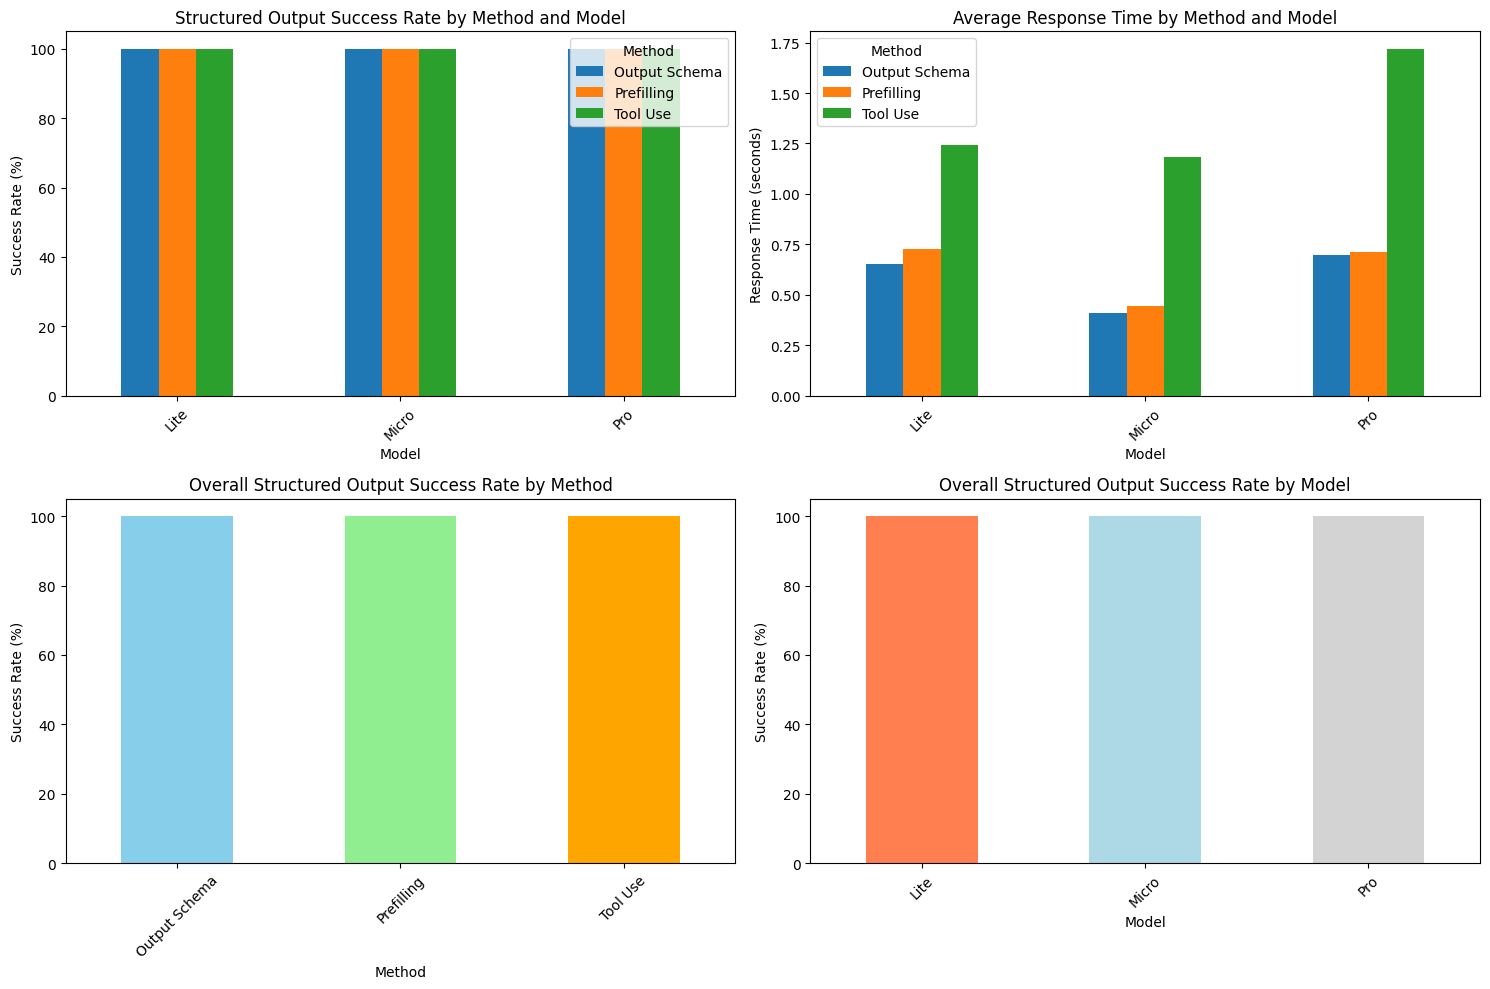

In [76]:
# Plot structured output success rates
plt.figure(figsize=(15, 10))

# Subplot 1: Success rates by method and model
plt.subplot(2, 2, 1)
pivot_structured.plot(kind='bar', ax=plt.gca())
plt.title('Structured Output Success Rate by Method and Model')
plt.ylabel('Success Rate (%)')
plt.xlabel('Model')
plt.legend(title='Method')
plt.xticks(rotation=45)

# Subplot 2: Average response times
plt.subplot(2, 2, 2)
duration_pivot = results_df.pivot_table(
    values='duration', 
    index='model', 
    columns='method', 
    aggfunc='mean'
)
duration_pivot.plot(kind='bar', ax=plt.gca())
plt.title('Average Response Time by Method and Model')
plt.ylabel('Response Time (seconds)')
plt.xlabel('Model')
plt.legend(title='Method')
plt.xticks(rotation=45)

# Subplot 3: Overall method comparison
plt.subplot(2, 2, 3)
method_summary = results_df.groupby('method')['is_structured'].mean() * 100
method_summary.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightgreen', 'orange'])
plt.title('Overall Structured Output Success Rate by Method')
plt.ylabel('Success Rate (%)')
plt.xlabel('Method')
plt.xticks(rotation=45)

# Subplot 4: Model comparison across all methods
plt.subplot(2, 2, 4)
model_summary = results_df.groupby('model')['is_structured'].mean() * 100
model_summary.plot(kind='bar', ax=plt.gca(), color=['coral', 'lightblue', 'lightgray'])
plt.title('Overall Structured Output Success Rate by Model')
plt.ylabel('Success Rate (%)')
plt.xlabel('Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Check Sample Outputs from Each Method

In [77]:
# Show sample successful outputs from each method
for method_name in test_methods.keys():
    print(f"\n{'='*60}")
    print(f"Sample Output from {method_name} Method")
    print(f"{'='*60}")
    
    # Find first successful structured response for this method
    successful_responses = [r for r in results if r["method"] == method_name and r["is_structured"]]
    
    if successful_responses:
        sample = successful_responses[0]
        print(f"Model: {sample['model']}")
        print(f"Success: {sample['success']}")
        print(f"Duration: {sample['response']['duration']:.2f}s")
        
        if method_name == "Tool Use":
            if sample['response']['tool_call']:
                print("Structured Output:")
                print(json.dumps(sample['response']['tool_call']['input'], indent=2))
        else:
            if sample['response']['json_output']:
                print("Structured Output:")
                print(json.dumps(sample['response']['json_output'], indent=2))
    else:
        print(f"No successful structured outputs found for {method_name} method")


Sample Output from Output Schema Method
Model: Pro
Success: True
Duration: 0.91s
Structured Output:
{
  "questionText": "What is the name of your healthcare practice?",
  "questionType": "text",
  "friendlyResponse": "Thank you for sharing the name of your healthcare practice! We appreciate your input.",
  "nextQuestionId": null
}

Sample Output from Prefilling Method
Model: Pro
Success: True
Duration: 0.75s
Structured Output:
{
  "questionText": "What is the name of your healthcare practice?",
  "questionType": "text",
  "friendlyResponse": "Thank you for sharing the name of your healthcare practice! We appreciate your input.",
  "nextQuestionId": "2"
}

Sample Output from Tool Use Method
Model: Pro
Success: True
Duration: 1.75s
Structured Output:
{
  "friendlyResponse": "Thank you for sharing the name of your healthcare practice!",
  "questionType": "text",
  "nextQuestionId": "healthcare_practice_name",
  "questionText": "What is the name of your healthcare practice?"
}
